# Imports

In [1]:
%reload_ext nb_black
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly
import seaborn as sns

%matplotlib inline

plt.style.use(["dark_background"])
# %matplotlib ipympl

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import LeaveOneOutEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
from functions_pkg import print_vif, predictions_df
from sklearn.metrics import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.calibration import calibration_curve

<IPython.core.display.Javascript object>

* Categorical or continuous
* 10,000+ samples
* 20+ features

age = days (int)

In [2]:
url = "https://raw.githubusercontent.com/taylor-m/class_notebooks/main/capstone_2/cardiovascular_disease_classifier/cardiovascular_disease_prediction/cardio_train.csv"
df = pd.read_csv(url, sep=";", index_col="id")

<IPython.core.display.Javascript object>

In [3]:
# path = "cardiovascular_disease_prediction/cardio_train.csv"
# df = pd.read_csv(path, sep=";", index_col="id")

<IPython.core.display.Javascript object>

In [4]:
# column renaming
mapping = {
    "ap_hi": "bp_hi",
    "ap_lo": "bp_lo",
    "gluc": "glucose",
    "alco": "alcohol",
    "cardio": "disease",
}

df = df.rename(columns=mapping)

<IPython.core.display.Javascript object>

In [5]:
# dataset is well balanced
df.disease.value_counts()

0    35021
1    34979
Name: disease, dtype: int64

<IPython.core.display.Javascript object>

In [6]:
# no null values in the data
df.isna().mean().sort_values(ascending=False)

disease        0.0
active         0.0
alcohol        0.0
smoke          0.0
glucose        0.0
cholesterol    0.0
bp_lo          0.0
bp_hi          0.0
weight         0.0
height         0.0
gender         0.0
age            0.0
dtype: float64

<IPython.core.display.Javascript object>

# Data Cleaning

In [7]:
# change gender to 0-1 binary
df.loc[:, "gender"] = df.gender - 1

<IPython.core.display.Javascript object>

In [8]:
# reduce interval in cholesterol & glucose from 1-3 to 0-2
df.loc[:, "cholesterol"] = df.cholesterol - 1
df.loc[:, "glucose"] = df.glucose - 1

<IPython.core.display.Javascript object>

# Exploration

In [9]:
num_cols = ["age", "bp_hi", "bp_lo"]


<IPython.core.display.Javascript object>

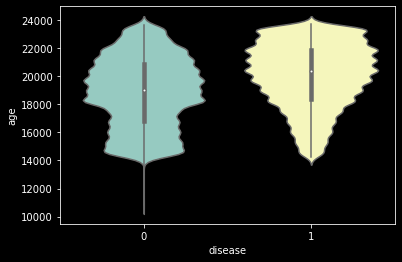

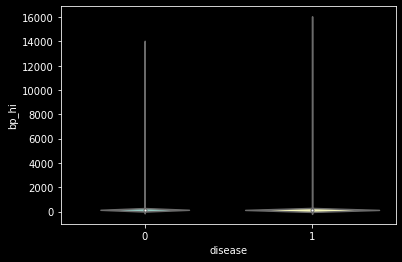

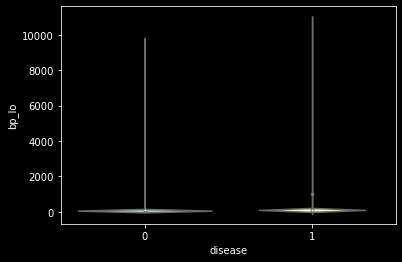

<IPython.core.display.Javascript object>

In [10]:
for col in num_cols:
    sns.violinplot(x="disease", y=col, data=df)
    plt.show()

## BP value errors

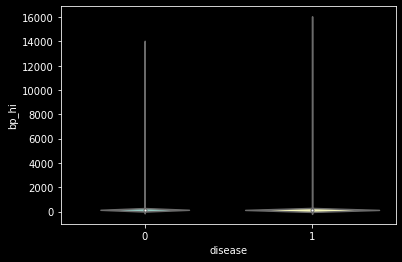

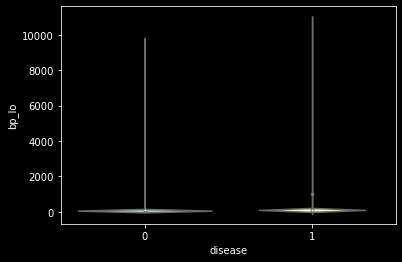

<IPython.core.display.Javascript object>

In [11]:
# extreme values in bp_hi need to be corrected
bp_cols = ["bp_hi", "bp_lo"]
for col in bp_cols:
    sns.violinplot(x="disease", y=col, data=df)
    plt.show()

In [12]:
# 993 samples with extreme values for bp_hi or bp_lo
idx = df[(abs(df.bp_hi) > 300) | (abs(df.bp_lo) > 200)].index
df = df.drop(index=idx)

<IPython.core.display.Javascript object>

In [13]:
# drop samples with negative bp_values
idx = df[(df.bp_hi < 0) | (df.bp_lo < 0)].index
df = df.drop(index=idx)

<IPython.core.display.Javascript object>

In [14]:
# drop samples with bp_hi or bp_lo values less than 50; data entry error
idx = df[(df.bp_lo < 50) | (df.bp_hi < 50)].index
df = df.drop(index=idx)

<IPython.core.display.Javascript object>

## Height value errors

In [15]:
# create column for height in ft
df["height_ft"] = df.height / 30.48

# drop samples with heights below 5 feet and above 7 feet
idx = df[(df.height_ft < 4.5) | (df.height_ft > 7)].index
df = df.drop(index=idx)

<IPython.core.display.Javascript object>

---
# Features

In [16]:
# blood pressure difference column
df["bp_diff"] = df.bp_hi - df.bp_lo

# BMI column to replace height and weight
# bmi = weight (kgs) / (height (m))^2
df["bmi"] = df.weight / (df.height / 100) ** 2

# added some more common measurement unit columns for better understanding
df["yrs"] = df.age / 365
df["height_ft"] = df.height / 30.48
df["weight_lbs"] = df.weight * 2.205

<IPython.core.display.Javascript object>

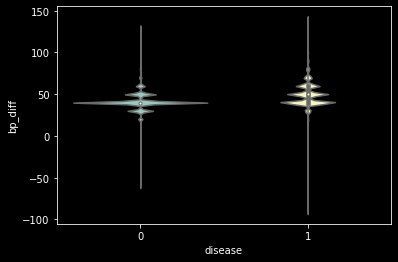

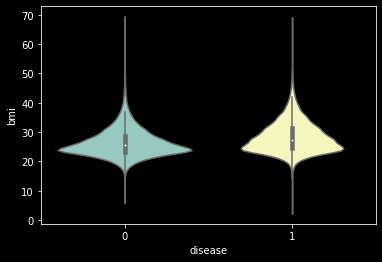

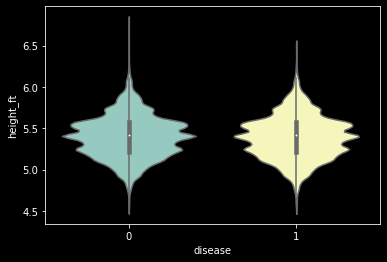

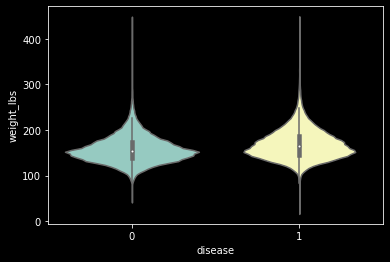

<IPython.core.display.Javascript object>

In [17]:
# extreme values in bp_hi need to be corrected
bp_cols = ["bp_diff", "bmi", "height_ft", "weight_lbs"]
for col in bp_cols:
    sns.violinplot(x="disease", y=col, data=df)
    plt.show()

In [18]:
# 68,621 samples after dropping errors
df.shape[0]

68621

<IPython.core.display.Javascript object>

# Gradient Boosting Model

In [19]:
drop_cols = [
    "disease",
    "yrs",
    "height_ft",
    "bp_diff",
    "weight_lbs",
    "active",
    #     "alcohol",
    #     "bmi",
    #         "height",
    #     "weight",
]

X = df.drop(columns=drop_cols)
y = df.disease

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=28, stratify=df.disease
)

<IPython.core.display.Javascript object>

> Categorical columns encoded; decision tree class models don't require numerical scaling

In [20]:
# categorical columns to be encoded
cat_cols = ["cholesterol", "glucose"]

# data preprocessing
preprocessing = ColumnTransformer(
    [
        ("encode_cats", LeaveOneOutEncoder(), cat_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [21]:
pipeline = Pipeline(
    [
        ("processing", preprocessing),
        ("model", XGBClassifier(use_label_encoder=False)),
    ]
)

pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"\ntrain score: {train_score}")
print(f"test score: {test_score}")

[23:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

train score: 0.7802972894199942
test score: 0.7269680277462038


<IPython.core.display.Javascript object>

---
## XGB hyperparameter tuning

XGBoost

In [22]:
# grid search values other than optimal hyperparameters removed to lower notebook run time
# fmt: off
grid = {
    "model__n_estimators": np.arange(1, 3),
    "model__learning_rate": np.arange(0, 50, 10),
    #     "model__subsample": [],
    "model__colsample_bytree": np.arange(0.7,1,0.1),
    "model__max_depth": np.arange(4,7),
}
# fmt: on
pipeline_cv = GridSearchCV(pipeline, grid, cv=2, verbose=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

best_params = pipeline_cv.best_params_
best_params

Fitting 2 folds for each of 120 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.7s


[23:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    6.3s finished


{'model__colsample_bytree': 0.9999999999999999,
 'model__learning_rate': 10,
 'model__max_depth': 5,
 'model__n_estimators': 1}

<IPython.core.display.Javascript object>

In [23]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"train_score {train_score}")
print(f"test_score {test_score}")

train_score 0.7354998542698922
test_score 0.7292413511701786


<IPython.core.display.Javascript object>

---
## XGB feature importance

In [24]:
feature_importances = pipeline_cv.best_estimator_["model"].feature_importances_
feature_importances = pd.DataFrame(
    {"feature": X_train.columns, "importance": feature_importances}
).sort_values("importance", ascending=False)
feature_importances

,feature,importance
6,cholesterol,0.751898
0,age,0.112131
2,height,0.093298
7,glucose,0.016017
1,gender,0.013034
10,bmi,0.008721
5,bp_lo,0.002887
4,bp_hi,0.002013
3,weight,0.000000
8,smoke,0.000000


<IPython.core.display.Javascript object>

---
## XGB predictions

In [25]:
y_preds = pipeline_cv.predict(X_test)
preds_df, fig = predictions_df(X_test, y_test, y_preds)

# confusion matrix
cm = confusion_matrix(y_test, y_preds)
display(cm)

# classification report
class_report = classification_report(y_test, y_preds)
print(class_report)

# prediction probabilities
pred_prob = pipeline_cv.predict_proba(X_test)
# add prediction probs to preds_df
preds_df["pred_prob"] = pred_prob[:, 1]

preds_df = preds_df.drop(columns=["residuals", "abs_residuals"])
# preds_df.head()

array([[13864,  3464],
       [ 5826, 11157]], dtype=int64)

              precision    recall  f1-score   support

           0       0.70      0.80      0.75     17328
           1       0.76      0.66      0.71     16983

    accuracy                           0.73     34311
   macro avg       0.73      0.73      0.73     34311
weighted avg       0.73      0.73      0.73     34311



<IPython.core.display.Javascript object>

In [26]:
adj_preds = preds_df.copy()
adj_preds

,age,gender,height,weight,bp_hi,bp_lo,cholesterol,glucose,smoke,alcohol,bmi,y_true,y_preds,pred_prob
id,,,,,,,,,,,,,,
73144,16253,0,165,66.0,120,80,0,0,0,0,24.242424,1,0,1.000000
23293,20299,0,150,84.0,130,90,1,0,0,0,37.333333,0,1,0.000160
71292,18092,0,158,73.0,120,80,1,1,0,0,29.242109,1,0,0.199098
38754,22096,1,175,100.0,120,80,0,2,0,0,32.653061,1,0,0.980427
55742,17497,1,165,121.0,110,80,0,1,0,0,44.444444,1,0,0.021898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99891,19834,0,164,85.0,165,110,2,2,0,0,31.603212,1,1,0.991102
17671,21099,0,152,86.0,120,70,0,0,0,0,37.222992,0,0,0.999995
22630,20480,0,175,77.0,140,90,0,0,0,1,25.142857,1,1,0.199098


<IPython.core.display.Javascript object>

In [27]:
# changing the prediction percentage threshold to 45%
adj_preds.loc[adj_preds.pred_prob > 0.49, "y_preds"] = 1

# classification report with new threshold
print(classification_report(adj_preds.y_true, adj_preds.y_preds))

              precision    recall  f1-score   support

           0       0.70      0.46      0.56     17328
           1       0.59      0.80      0.68     16983

    accuracy                           0.63     34311
   macro avg       0.65      0.63      0.62     34311
weighted avg       0.65      0.63      0.62     34311



<IPython.core.display.Javascript object>

---
## XGB error analysis

> False negatives

In [28]:
# dataframe for false negatives sorted by prediction probability descending
f_negs = preds_df[(preds_df.y_true == 1) & (preds_df.y_preds == 0)].sort_values(
    "pred_prob", ascending=False
)
f_negs

,age,gender,height,weight,bp_hi,bp_lo,cholesterol,glucose,smoke,alcohol,bmi,y_true,y_preds,pred_prob
id,,,,,,,,,,,,,,
73144,16253,0,165,66.0,120,80,0,0,0,0,24.242424,1,0,9.999995e-01
33983,20574,0,166,70.0,110,70,0,0,0,0,25.402816,1,0,9.999995e-01
10389,20451,1,185,75.0,120,80,0,0,0,0,21.913806,1,0,9.999995e-01
94860,17609,1,164,82.0,120,80,1,0,0,0,30.487805,1,0,9.999995e-01
9683,16656,0,152,66.0,130,80,0,0,0,0,28.566482,1,0,9.999995e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87930,18286,0,164,67.0,130,80,0,0,0,0,24.910767,1,0,3.542556e-07
42199,21302,1,182,81.0,125,80,0,0,1,0,24.453568,1,0,3.542556e-07
62914,17703,1,167,98.0,110,80,0,1,0,0,35.139302,1,0,3.542556e-07


<IPython.core.display.Javascript object>

In [29]:
f_negs.mean()

age            19326.393066
gender             0.329386
height           164.653278
weight            73.579900
bp_hi            118.499828
bp_lo             77.894439
cholesterol        0.185719
glucose            0.174219
smoke              0.067628
alcohol            0.038277
bmi               27.188290
y_true             1.000000
y_preds            0.000000
pred_prob          0.422753
dtype: float64

<IPython.core.display.Javascript object>

> prediction probability distribution

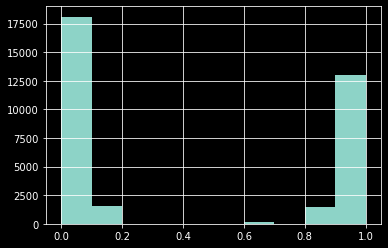

<IPython.core.display.Javascript object>

In [30]:
preds_df.pred_prob.hist()

> predicitve value of XGBoost model is limited

---
---
# Logistic Regression Model

In [57]:
# drop columns for testing sets
drop_cols = [
    "disease",
    "yrs",
    "height_ft",
    "bp_diff",
    "weight_lbs",
    "active",
    "alcohol",
    "bmi",
    #     "height",
    #     "weight",
]

# train test split of data
X = df.drop(columns=drop_cols)
y = df.disease

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=28, stratify=df.disease
)

<IPython.core.display.Javascript object>

In [58]:
num_cols = [
    "age",
    "height",
    "weight",
    "bp_hi",
    "bp_lo",
]

preprocessing = ColumnTransformer(
    [
        ("encode_cats", LeaveOneOutEncoder(), cat_cols),
        ("scaler", StandardScaler(), num_cols),
        #         ("scaler", MinMaxScaler(), num_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [59]:
# fmt: off
lr_pipeline = Pipeline(
    [
        ("processing", preprocessing),
        ("model", LogisticRegression(solver="lbfgs", penalty="none", max_iter=1000, random_state=28))
    ]
)

lr_pipeline.fit(X_train, y_train)

# best_params = pipeline.best_params_
lr_train_score = lr_pipeline.score(X_train, y_train)
lr_test_score = lr_pipeline.score(X_test, y_test)

print(f"train score: {lr_train_score}")
print(f"test score: {lr_test_score}")

train score: 0.7273571844943165
test score: 0.7203642987249544


<IPython.core.display.Javascript object>

---
## LR hyperparameter tuning

In [60]:
# fmt: off
lr_grid = {
    "model__solver": ['lbfgs'],
    "model__penalty": ["l2","none"],
    "model__C": [0.75],
}
# fmt: on
lr_pipeline_cv = GridSearchCV(lr_pipeline, lr_grid, cv=5, verbose=1, n_jobs=2)
lr_pipeline_cv.fit(X_train, y_train)

lr_best_params = lr_pipeline_cv.best_params_
lr_best_params

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.4s finished


{'model__C': 0.75, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

<IPython.core.display.Javascript object>

In [61]:
lr_train_score = lr_pipeline_cv.score(X_train, y_train)
lr_test_score = lr_pipeline_cv.score(X_test, y_test)

print(f"train_score {lr_train_score}")
print(f"test_score {lr_test_score}")

train_score 0.7273389682308364
test_score 0.7203642987249544


<IPython.core.display.Javascript object>

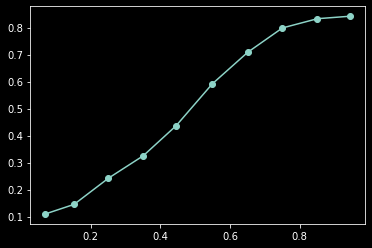

<IPython.core.display.Javascript object>

In [62]:
lr_pred_prob = lr_pipeline_cv.predict_proba(X_test)
# pred_prob

lr_prob_true, lr_prob_pred = calibration_curve(y_test, lr_pred_prob[:, 1], n_bins=10)
plt.plot(lr_prob_pred, lr_prob_true, "-o")
plt.show()

---
## LR predictions

In [63]:
# prediction percentages
lr_preds = lr_pipeline_cv.predict(X_test)

# df created from predictions
lr_preds_df, _ = predictions_df(X_test, y_test, lr_preds)

# add prediction probs to preds_df
lr_preds_df["pred_prob"] = lr_pred_prob[:, 1]

# classification target, residuals not needed
lr_preds_df = lr_preds_df.drop(columns=["residuals", "abs_residuals"])

# confusion matrix
lr_cm = confusion_matrix(y_test, lr_preds)
display(lr_cm)

# classification report
print(classification_report(y_test, lr_preds))

array([[5415, 1516],
       [2322, 4472]], dtype=int64)

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      6931
           1       0.75      0.66      0.70      6794

    accuracy                           0.72     13725
   macro avg       0.72      0.72      0.72     13725
weighted avg       0.72      0.72      0.72     13725



<IPython.core.display.Javascript object>

---
## LR error analysis

In [64]:
# dataframe for false negatives sorted by prediction probability descending
lr_f_negs = lr_preds_df[
    (lr_preds_df.y_true == 1) & (lr_preds_df.y_preds == 0)
].sort_values("pred_prob", ascending=False)

<IPython.core.display.Javascript object>

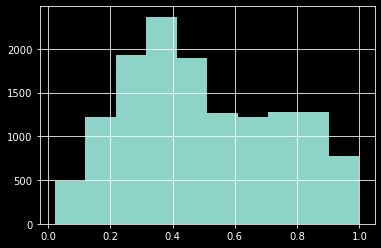

<IPython.core.display.Javascript object>

In [65]:
lr_preds_df.pred_prob.hist()

> The overall classification ability of the logistic regression model isn't quite as good as the XGBoost model, however the predictive range of the logistic regression model is more versatile

In [66]:
lr_f_negs.mean()

age            19298.566322
gender             0.364772
height           165.084410
weight            71.845564
bp_hi            118.033592
bp_lo             77.848837
cholesterol        0.134367
glucose            0.158484
smoke              0.070629
y_true             1.000000
y_preds            0.000000
pred_prob          0.491242
dtype: float64

<IPython.core.display.Javascript object>

In [67]:
f_negs.mean()

age            19326.393066
gender             0.329386
height           164.653278
weight            73.579900
bp_hi            118.499828
bp_lo             77.894439
cholesterol        0.185719
glucose            0.174219
smoke              0.067628
alcohol            0.038277
bmi               27.188290
y_true             1.000000
y_preds            0.000000
pred_prob          0.422753
dtype: float64

<IPython.core.display.Javascript object>

In [68]:
lr_preds_df.head()

,age,gender,height,weight,bp_hi,bp_lo,cholesterol,glucose,smoke,y_true,y_preds,pred_prob
id,,,,,,,,,,,,
82877,17285,1,183,99.0,120,80,0,0,0,1,0,0.524032
60787,21861,0,174,73.0,150,80,2,2,0,0,1,0.406087
66111,18930,0,160,71.0,110,70,0,0,0,1,0,0.918922
11794,19807,1,178,78.0,120,90,0,0,0,1,0,0.815680
22742,23479,0,169,65.0,120,80,0,0,0,1,0,0.686403


<IPython.core.display.Javascript object>

## Prediction threshold

In [69]:
adj_lr_preds = lr_preds_df.copy()

<IPython.core.display.Javascript object>

In [70]:
# changing the prediction percentage threshold
adj_lr_preds.loc[adj_lr_preds.pred_prob > 0.4999, "y_preds"] = 1

# classification report with new threshold
print(classification_report(adj_lr_preds.y_true, adj_lr_preds.y_preds))

              precision    recall  f1-score   support

           0       0.70      0.44      0.54      6931
           1       0.58      0.80      0.68      6794

    accuracy                           0.62     13725
   macro avg       0.64      0.62      0.61     13725
weighted avg       0.64      0.62      0.61     13725



<IPython.core.display.Javascript object>